In [0]:
#!pip install tensorflow==1.4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from IPython.display import display
import matplotlib.pyplot as plt
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter
#import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics


import os

## Reading UCI-HAR

In [0]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def signal_reader(filename):
    with open(filename, 'r') as fp:
        d = fp.read().splitlines()
        d = map(lambda x: x.rstrip().lstrip().split(), d)
        d = [list(map(float, line)) for line in d]
    return d

def label_reader(filename):        
    with open(filename, 'r') as fp:
        act = fp.read().splitlines()
        act = list(map(int, act))
    return act

def randomizer(dataset, labels):
    p = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[p, :, :]
    shuffled_labels = labels[p]
    return shuffled_dataset, shuffled_labels

train_fold = '/content/drive/My Drive/UCI HAR Dataset-Full/train/Inertial Signals/'
test_fold = '/content/drive/My Drive/UCI HAR Dataset-Full/test/Inertial Signals/'

train = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

test = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

train_y_files = '/content/drive/My Drive/UCI HAR Dataset-Full/train/y_train.txt'
test_y_files = '/content/drive/My Drive/UCI HAR Dataset-Full/test/y_test.txt'

arr_train_signals, arr_test_signals = [], []

for inp_file in train:
    signal = signal_reader(train_fold + inp_file)
    arr_train_signals.append(signal)
arr_train_signals = np.transpose(np.array(arr_train_signals), (1, 2, 0))

for inp_file in test:
    signal = signal_reader(test_fold + inp_file)
    arr_test_signals.append(signal)
arr_test_signals = np.transpose(np.array(arr_test_signals), (1, 2, 0))

labels_train = label_reader(train_y_files)
labels_test = label_reader(test_y_files)

[no_signals_train, no_steps_train, no_components_train] = np.shape(arr_train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(arr_train_signals)
no_labels = len(np.unique(labels_train[:]))

print("The train  has {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test  has {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train  has {} labels, with the following distribution:\n {}".format(np.shape(labels_train)[0], Counter(labels_train[:])))
print("The test  has {} labels, with the following distribution:\n {}".format(np.shape(labels_test)[0], Counter(labels_test[:])))

x_train, y_train = randomizer(arr_train_signals, np.array(labels_train))
x_test, y_test = randomizer(arr_test_signals, np.array(labels_test))

The train  has 7352 signals, each one of length 128 and 9 components 
The test  has 7352 signals, each one of length 128 and 9 components 
The train  has 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test  has 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


In [0]:
 len(arr_train_signals[0])  # 128 timesteps per series
 len(arr_train_signals[0][0])

9

In [0]:
print(np.array(arr_train_signals).shape)
print(np.array(arr_test_signals).shape)

(7352, 128, 9)
(2947, 128, 9)


## LSTM

In [0]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History,EarlyStopping 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import backend as K



def recall_m(true_Y, pred_Y):
        TP = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(true_Y, 0, 1)))
        rec = TP / (possible_pos + K.epsilon())
        return rec

def precision_m(true_Y, pred_Y):
        true_positives = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(pred_Y, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(true_Y, pred_Y):
    pres = precision_m(true_Y, pred_Y)
    rec = recall_m(true_Y, pred_Y)
    return 2*((pres*rec)/(pres+rec+K.epsilon()))

In [0]:
# calısan


from keras.layers import LSTM,Lambda
from keras import Model


class lstm(object):
  def __init__(self,
               class_num=6,
               last_activation='softmax'):

      self.class_num = 6
      self.last_activation = last_activation

  def forward(self):
    
      img_inputs  = keras.Input((128,9))
      
      print(img_inputs.shape)
      
      

      
      x=LSTM(64, return_sequences=False)(img_inputs) 
      print(x.shape)


      x = keras.layers.Dense(128, activation='relu')(x)
      print(x.shape)


      output = Dense(self.class_num, activation=self.last_activation)(x)
      print(output.shape)

      model = Model(inputs=img_inputs, outputs=output)


      return model


def lstm_train(X_train,y_train,X_test,y_test):
  
  history = History()

  num_classes = 6
  batch_size = 64
  epochs = 50
  early_stopping = [EarlyStopping(monitor='val_loss',min_delta=0,restore_best_weights=True, patience=7,verbose=1, mode='auto')]
 


  model=lstm().forward()
  model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(lr=0.01), 
                metrics=['accuracy',f1_m,precision_m, recall_m])

  history=model.fit(X_train, y_train, batch_size=batch_size, 
            epochs=epochs, verbose=1, 
            validation_split=0.1, 
            callbacks=early_stopping)

  

  loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=1)
  print(" CNN Training Loss: {:.4f}".format(loss))
  print(" CNN Training Accuracy: {:.4f}".format(accuracy))
  print(" CNN Training f1 score: {:.4f}".format(f1_score))
  print(" CNN Training Precision: {:.4f}".format(precision))
  print(" CNN Training Recall: {:.4f}".format(recall))


  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
  print(" CNN Test Loss: {:.4f}".format(loss))
  print(" CNN Test Accuracy: {:.4f}".format(accuracy))
  print(" CNN Test f1 score: {:.4f}".format(f1_score))
  print(" CNN Test Precision: {:.4f}".format(precision))
  print(" CNN Test Recall: {:.4f}".format(recall))


  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

  number_of_epochs_it_ran = len(history.history['accuracy'])

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Accuracy', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Accuracy', fontsize=18)
  axarr[1].set_ylim([0.80,1])
  plt.legend()
  plt.show()


In [0]:
#batch,epoch,lr must be added to the function params.

def indexing (arr):
  new=[]
  for a in  arr:
    new.append(a-1)

  return np.array(new)

y_train=indexing(y_train)
y_test=indexing(y_test)

def one_hot(y_, n_classes=6):
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



(7352, 128, 9) (7352,) (2947, 128, 9) (2947,)
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]
(None, 128, 9)
(None, 64)
(None, 128)
(None, 6)
Train on 6616 samples, validate on 736 samples
Epoch 1/50
6616/6616 [==============================] - 30s 5ms/step - loss: 0.7793 - accuracy: 0.6601 - f1_m: 0.6135 - precision_m: 0.7958 - recall_m: 0.5323 - val_loss: 0.3817 - val_accuracy: 0.8247 - val_f1_m: 0.8296 - val_precision_m: 0.8492 - val_recall_m: 0.8112
Epoch 2/50
6616/6616 [==============================] - 28s 4ms/step - loss: 0.3947 - accuracy: 0.8407 - f1_m: 0.8402 - precision_m: 0.8576 - recall_m: 0.8249 - val_loss: 0.1488 - val_accuracy: 0.9443 - val_f1_m: 0.9440 - val_precision_m: 0.9440 - val_recall_m: 0.9440
Epoch 3/50
6616/6616 [==============================] - 28s 4ms/step - loss: 0.2367 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9198 - recall_m: 0.9137 - val_loss: 0.1447 - val_accur

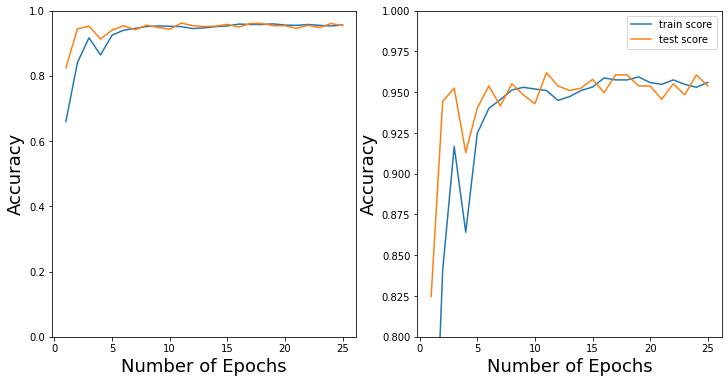

In [0]:

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
#history_lstm=lstm_train(x_train,one_hot(y_train),x_test,one_hot(y_test))
print(one_hot(y_test))

history_lstm=lstm_train(x_train,one_hot(y_train),x_test,one_hot(y_test))